In [3]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

# 2. 전처리
## 2-1 결측치 처리

In [7]:
from numpy.random import randint

wine = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv",
                  index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

wine_m = wine.copy()
for col in ['Alcohol', 'Ash']:
    random_idx = randint(0, len(wine), 25)
    wine_m.loc[random_idx, col] = np.nan
print(wine_m.isna().sum())

Alcohol      23
Malicacid     0
Ash          23
Magnesium     0
Hue           0
dtype: int64


In [9]:
from sklearn.impute import SimpleImputer

# 결측치를 0으로 대치
wine_imp = wine_m.fillna(0)

# 결측치를 대표값으로 대치
# strategy = 'mean', 'median', or 'most_frequent'
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
wine_imp1 = imputer.fit_transform(wine_m)
wine_imp1 = pd.DataFrame(wine_imp1, columns=wine_m.columns)

### 단순확률대치법
- 유사한 데이터셋에서 랜덤하게 샘플링한 값으로 대치
    - Hot-deck : 현재 진행중인 연구에서 비슷한 성향 데이터 중 랜덤 선택
    - Cold-deck : 외부 출처 혹은 비슷한 연구에서 대체할 데이터 가져오는 것

In [10]:
# Hot-Deck
# wine이 wine_m과 비슷한 성향이라고 가정하고 wine에서 랜덤하게 선택하여 wine_m 대치
wine_imp2 = wine_m.copy()

for feature in ['Alcohol', 'Ash']:
    missing_idx = wine_imp2.loc[wine_imp2[feature].isna()==True].index
    wine_imp2.loc[missing_idx, feature] = wine[feature].sample(len(missing_idx)).values

### 다른 변수들로 모델링하여 결측값 예측
- KNN imputer : 정확할 때가 많지만, 전체 데이터셋을 올려야해서 메모리가 많이 필요하고 이상치에 민감, 
- 기타 회귀 및 분류 알고리즘 이용 가능

In [11]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
wine_imp3 = imputer.fit_transform(wine_m)
wine_imp3 = pd.DataFrame(wine_imp3, columns=wine_m.columns)

### 보간법
- 시계열 데이터 결측치 대치 : linear, polynomial, spline
- 맨 앞의 결측치는 보간되지 않으므로 단순하게 다음값으로 채움

In [12]:
wine_imp4 = wine_m.interpolate(method='linear')

## 2-2. 이상치 처리
- 이상치 데이터 판정기준

1) ESD : mean-3\*std < data < mean+3\*std 

2) 기하평균 - 2.5 \* std < data < 기하평균 + 2.5 \* std

3) Q1 - 1.5\* IQR < data < Q3 + 1.5\* IQR

4) DBSCAN 통해 -1로 분류되는 값

- 이상치 처리방법 : 절단, 조정, 클리핑

### 절단
- 절단 후 새로운 이상치 생길 수 있으나 이는 분석가가 상황에 맞게 설정 필요

In [14]:
wine = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv",
                  index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

IQR = wine['Malicacid'].quantile(0.75) - wine['Malicacid'].quantile(0.25)
top = wine['Malicacid'].quantile(0.75) + IQR * 1.5
down = wine['Malicacid'].quantile(0.25) - IQR * 1.5

out_id = wine.loc[(wine['Malicacid']>=top) | (wine['Malicacid']<=down)].index

# 절단
prep_df = wine[['Malicacid']].drop(out_id, axis=0)

### 조정
- 이상치를 앞서 정해진 이상치의 상한과 하한선으로 보정

In [15]:
prep_df2 = wine[['Malicacid']].clip(down, top)

### 클리핑
- 이상치 상, 하한을 특정값으로 지정하여, 벗어나는 값을 조정
- 이상치 경계값에 대한 확실한 정보를 가지고 있거나, 데이터를 특정 경계값으로 제한하고 싶을 때

In [16]:
prep_df3 = wine[['Malicacid']].clip(1,5)

## 2-3 클래스 불균형 처리
- 오버샘플링 & 언더샘플링

In [17]:
from sklearn.datasets import load_breast_cancer
from collections import Counter

data = load_breast_cancer()
df = pd.DataFrame(np.c_[data['data'], data['target']], 
                  columns = list(data.feature_names) + ['target'])

df = df.filter(['mean radius', 'mean texture', 'mean area', 'target'])
print("3 front rows: \n", df.head(3), "\n")
print("original data class distribution:", Counter(df['target']))


df1 = df.loc[df['target']==0].sample(50)
df2 = df.loc[df['target']==1].sample(250)
imb_df = pd.concat([df1, df2]).reset_index(drop=True)
print("imbalanced data class distribution: ", Counter(imb_df['target']))

features = imb_df.drop('target', axis=1)
target = imb_df['target']

3 front rows: 
    mean radius  mean texture  mean area  target
0        17.99         10.38     1001.0     0.0
1        20.57         17.77     1326.0     0.0
2        19.69         21.25     1203.0     0.0 

original data class distribution: Counter({1.0: 357, 0.0: 212})
imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})


### 랜덤 오버샘플링
- 기존에 존재하는 소수의 클래스를 단순복제
- 분포의 편화는 없으나 소수 클래스인 데이터가 많아지면서 해당 클래스에 대한 가중치가 높아지게 된다. 한편 단순히 동일 데이터의 증가이므로 과적할 될 수도 있다

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


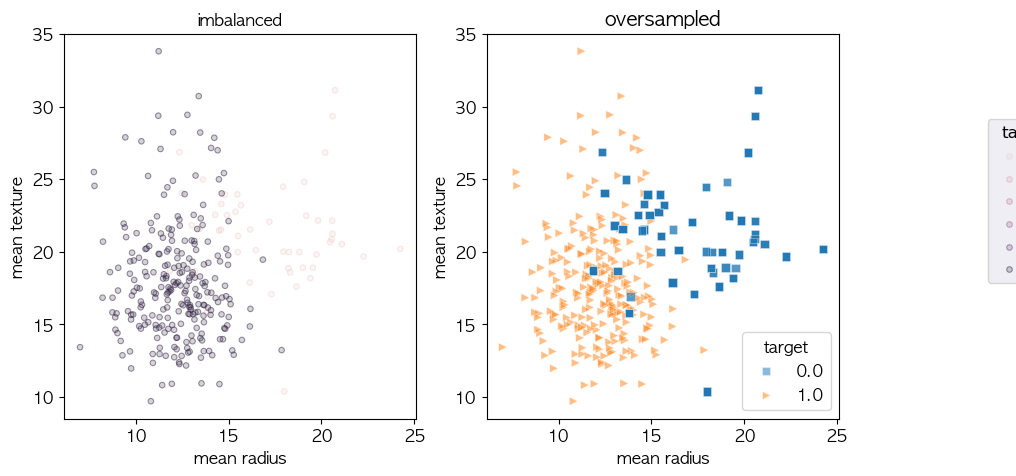

In [40]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(random_state=0)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df1 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
so.Plot(data=imb_df, x='mean radius', y='mean texture', color='target').add(so.Dots(alpha=0.5))\
 .label(title='imbalanced').on(ax[0]).plot()

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df1,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);

plt.show()

### SMOTE (synthetic minority oversampling technique)
- 임의의 소수 클래스 데이터로부터 인근 소수 클래스 사이에 새로운 데이터 생성
    - 임의의 소수 클래스 x를 잡고 가장 가까운 k개의 이웃을 찾은 다음, k개의 이웃과 x사이에 임의의 새로운 데이터 x' 생성

In [41]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df2 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


### Borderline SMOTE
- 다수, 소수의 클래스를 구분하는 선을 그을 때 서로 인접해있는 경계선에 있는 소수 클래스의 데이터에 대해서 SMOTE
    - 임의의 소수 클래스 데이터 x와 근접하는 데이터들의 클래스를 살펴보고 여기에 소수와 다수 클래스가 모두 존재하면 이 데이터를 경계데이터롤 분류한다. 
    - 그렇지 않은 경우 소수 클래스 데이터 x는 고려하지 않는다

In [42]:
from imblearn.over_sampling import BorderlineSMOTE

os = BorderlineSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df3 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


### K-means SMOTE

In [47]:
from imblearn.over_sampling import KMeansSMOTE

os = KMeansSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df4 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 251, 1.0: 250})


### SVM SMOTE
- 소수 클래스인 support vector 데이터들을 경계데이터로 삼고 SMOTE 적용

In [48]:
from imblearn.over_sampling import SVMSMOTE

os = SVMSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df5 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


### ADASYN (Adaptive synthetic sampling)
- 가중치를 통한 SMOTE
    - 인접한 데이터의 소수 클래스와 다수 클래스의 비율에 따라 생성되는 샘플의 개수 정해짐
    - 생성 샘플계수 : 소수 클래스 필도에 반비례

In [49]:
from imblearn.over_sampling import ADASYN

os = ADASYN(random_state=0, n_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df6 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 258, 1.0: 250})


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

data = [imb_df, over_df1, over_df2, over_df3, over_df4, over_df5, over_df6]
data_title = ['no oversampling', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 
              'KMeansSMOTE', 'SVMSMOTE', 'ADASYN']

scores = pd.DataFrame(index=['train acc', 'test acc', 'train f1', 'test f1'], columns=data_title)

for df, title in zip(data, data_title):
    features = df.drop('target', axis=1)
    target = df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
    lr = LogisticRegression(max_iter=30)
    lr.fit(X_train, y_train)
    
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    
    scores.loc['train acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['test acc', title] = accuracy_score(y_test, pred_test)
    scores.loc['train f1', title] = f1_score(y_train, pred_train)
    scores.loc['test f1', title] = f1_score(y_test, pred_test)

scores

,no oversampling,RandomOverSampler,SMOTE,BorderlineSMOTE,KMeansSMOTE,SVMSMOTE,ADASYN
train acc,0.942222,0.882667,0.88,0.821333,0.976,0.856,0.779528
test acc,0.92,0.848,0.864,0.816,0.928571,0.808,0.795276
train f1,0.966057,0.891626,0.889435,0.833747,0.97733,0.861538,0.792079
test f1,0.953846,0.834783,0.849558,0.788991,0.921739,0.781818,0.775862


## 2-4 변수변환
- 특성의 scale을 바꾸는 것, 각 특성에 개별적 수행 => **트리 기반을 제외한 모델은 변수전환이 필수적**

### 2-4-1 수치형 변수변환
- 선형변환 : 표준화, 최소최대 스케일링, robust scaling, quantile scaling
- 비선형변환 : 로그벼환, box-cox, yeo-johnson
- 구간분할
- 순위 변환

In [51]:
diabetes = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_diabetes.csv")

X = diabetes[['Pregnancies', 'BloodPressure', 'BMI', 'Age']]
y = diabetes['Outcome']

### 표준화
- $\frac{데이터포인트 - 데이터\ 평균}{데이터\ 표준편차}$ : 평균을 0, 분산을 1로 변경하여 모든 특성이 같은 크기를 가지게 한다.
- 표준점수 z는 원수치가 평균에서 얼마나 떨어져있나 나타내나, 최소 최대값의 크기를 제한하지는 않는다.ㅡ

In [55]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_X = ss.fit_transform(X)
ss_X = pd.DataFrame(ss_X, columns=X.columns)

### 최소최대 스케일링
- 모든 특성이 정확하게 0-1 : $\frac{데이터값 - 최솟값}{최댓값-최솟값}$
- 처음부터 범위가 정해진 변수는 최소최대 스케일링이 자연스러움
- 변환 후에 평균이 정확이 0이 되지 않고, 이상치의 영향력이 커, 표준화 방법이 더 자주 쓰인다

In [56]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
mm_X = mm.fit_transform(X)
mm_X = pd.DataFrame(mm_X, columns=X.columns)

### Robust scaling
- 특성이 같은 스케일이라 표준화 스케일링과 비슷하나, 평균과 분산 대신 중앙값과 사분위수를 사용한다. 
- 이상치의 영향력이 없음 $\frac{데이터 - 중앙값}{3사분위수-1사분위수}$

In [57]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
rs_X = rs.fit_transform(X)
rs_X = pd.DataFrame(rs_X, columns=X.columns)

### Quantile Scaling
- 균등분포, 정규분포에 가깝게 데이터 변환
- 데이터의 1000개의 분위를 사용하여 분포를 재배치 : 이상치에 민감하지 않으며 전체 데이터를 0~1사이로 압축
    - 기본값보다 작은 크기의 데이터가 입력될 경우, 데이터의 개수대로 n_quantiles값 설정
    - Rank Gauss 방법으로서 수치형 변수를 순위로 변환한 뒤 순서를 유지한 채 정규분포가 되도록
    - 전체 데이터를 -5 ~ 5사이로 압축

In [58]:
from sklearn.preprocessing import QuantileTransformer
# uniform, normal
qtu = QuantileTransformer(output_distribution='uniform', n_quantiles=len(X))
qtu_X = qtu.fit_transform(X)
qtu_X = pd.DataFrame(qtu_X, columns=X.columns)

### 로그변환
- 큰 수의 범위를 압축하고, 작은 수의 범위르 확장

In [59]:
np.log1p(39.07)

np.float64(3.6906279246480533)

### 거듭제곱 변환
- Box-cox : 데이터를 정규 분포에 가깝게 만들거나, 데이터 분산 안정화, 양수 데이터에만 적용 가능
- Yeo-Johnson : 데이터 분산 안정화, 음수를 포함하는 실수 전체 적용 가능

In [62]:
realestate = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_BHP.csv').dropna().reset_index(drop=True) # 결측치 삭제 후, 인덱스 리셋
X = realestate[['bath', 'balcony']] # 수치형 변수 두개만 사용
y = realestate[['price']]

In [63]:
from sklearn.preprocessing import PowerTransformer

PTB = PowerTransformer(method='box-cox')
PTY = PowerTransformer(method='yeo-johnson')
y_ptb = pd.DataFrame(PTB.fit_transform(np.reshape([y], (-1,1))))
y_pty = pd.DataFrame(PTY.fit_transform(np.reshape([y], (-1,1))))
y_ptb_inv = pd.DataFrame(PTB.inverse_transform(y_ptb))

print("raw: ", y.head(1).values)
print("box-cox: ", y_ptb.head(1).values)
print("box-cox inv: ", y_ptb_inv.head(1).values)

raw:  [[39.07]]
box-cox:  [[-1.06667464]]
box-cox inv:  [[39.07]]


### 순위로 변환
- 데이터를 순위로 변환한 후 순위를 전체 데이터의 개수로 나누면 모든 데이터 값이 0~1범위에 들어감
  - 수치의 크기나 간격 정보는 소실

In [64]:
rank_X = X.rank(ascending=False)
display(rank_X.describe().loc[['mean', 'std', 'max', 'min'], :], )

,bath,balcony
mean,3748.500000,3748.50000
std,1926.118911,2010.62683
max,7282.500000,7295.50000
min,2.000000,503.00000


### 구간 분할
- 수치형 변수를 구간 별로 나누어 범주형 변수로 변환하는 방법
    - 순서가 있는 범주형 변수 : 순서를 수치화하여 사용
    - 범주형 변수로서 원핫 인코딩 적용 가능
- cut : bin수를 지정하거나 bin의 범위 지정
- KBinsDiscretizer : n_bins에 구간 수를 지정하여, 각 구간을 하나의 특성으로 삼는 원핫 인코딩 적용

In [67]:
X

,bath,balcony
0,2.0,1.0
1,5.0,3.0
2,3.0,1.0
3,2.0,1.0
4,5.0,3.0
...,...,...
7491,2.0,1.0
7492,3.0,3.0
7493,4.0,0.0
7494,2.0,1.0


In [72]:
pd.cut(X['bath'], bins=4).value_counts().reset_index()

,bath,count
0,"(0.992, 3.0]",6774
1,"(3.0, 5.0]",642
2,"(5.0, 7.0]",77
3,"(7.0, 9.0]",3


In [75]:
# bin 수 지정
binned = pd.cut(X['bath'], bins=4)
freq_df = pd.DataFrame(binned.value_counts()).reset_index().rename(columns={'bath':'계급', 'count':'빈도'}).sort_values(by='계급', ascending=True)

# bin 범위 지정
bin_edges = [0, 2, 4, 6, float('inf')]
binned2 = pd.cut(X['bath'], bin_edges, right=False)
freq_df2 = pd.DataFrame(binned2.value_counts()).reset_index().rename(columns={'bath':'계급', 'count':'빈도'}).sort_values(by='계급', ascending=True)

# KBins
from sklearn.preprocessing import KBinsDiscretizer

kb = KBinsDiscretizer(n_bins=3, strategy='quantile')
kb.fit(np.array(X['bath']).reshape(-1,1))
print("bin edges: ", kb.bin_edges_[0], '\n')

kbbin = kb.bin_edges_[0]
bin_edges = []
for i in range(len(kbbin)):
    if len(kbbin)-1 != i:
        tup = (int(kbbin[i]), int(kbbin[i+1]))
        bin_edges.append(tup)
kbinned = kb.transform(np.array(X['bath']).reshape(-1,1))        
result = pd.DataFrame(kbinned.toarray(), columns=bin_edges)
print(result.head(3))

bin edges:  [1. 2. 3. 9.] 

   (1, 2)  (2, 3)  (3, 9)
0     0.0     1.0     0.0
1     0.0     0.0     1.0
2     0.0     0.0     1.0


### 2-4-2 범주형 변수 변환
- 원핫인코딩, 더미코딩, 숫자로 표현된 범주형 특성 변환, 레이블 인코딩, 특징 해싱, 빈도 인코딩

In [76]:
estate = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-4_BHP.csv").dropna().reset_index(drop=True)

### 원핫 인코딩
- 범주형 변수의 모든 수준을 각각 새로운 특성으로 삼아서 0,1을 가지도록 데이터 변환
    - 더미코딩과 유사하지만, 더미코딩은 모든 수준 중에서 한 가지 수준은 제외하고 나머지 수준들로 새로운 특성을 삼음

In [78]:
print("범주형 변수의 수준 갯수: ", estate[['area_type']].nunique())
print(estate[['area_type']].head(5), '\n')

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
result = pd.DataFrame(ohe.fit_transform(estate[['area_type']]).toarray(), columns=ohe.get_feature_names_out())

범주형 변수의 수준 갯수:  area_type    4
dtype: int64
              area_type
0  Super built-up  Area
1            Plot  Area
2  Super built-up  Area
3  Super built-up  Area
4            Plot  Area 



### 더미코딩
- 범주형 변수의 수준이 n개 일때 가변수를 n개 만들어버리면 다중공선성이 생기므로 이를 방지하기 위해 n-1개의 가변수를 만드는 것
    - pd.get_dummies(drop_first=True)
    - 범주형 변수의 수준 개수가 너무 많을 경우 정보가 적은 특징의 대량 생산가능 => 다른 인코딩 혹은 수준 갯수 줄이는 방법 생각

In [79]:
result2 = pd.get_dummies(estate['area_type'], drop_first=True)

### 숫자로 표현된 범주형 특성 변환
- 명목척도인 변수임에도 불구하고 데이터 작성규칙에 따라 단순히 숫자로 입력되어 있는 경우라면, 연속형 변수로 다루면 안된다. 이를 위해 해당 타입을 범주형으로 변경하는 방법 사용

In [80]:
estate['area_type'] = estate['area_type'].map({'Super built-up  Area':0, 'Plot  Area':1, 'Built-up  Area':2, 'Carpet  Area':3})
estate['area_type'] = estate['area_type'].astype('category')

### 레이블 인코딩
- 판다스 시리즈 + replace, map / LabelEncoder
    - 사이킷런 : 범주명을 오름차순으로 정렬하여 자동으로 수치를 매기므로, 서열의 대응 여부를 classes_로 확인 필요
- 서열척도 : 순서의 정보를 가지는 수치형 레이블 그대로 사용
- 명목척도 : 레이블 수치는 의미가 없으므로 원핫인코딩이나 더미 코딩

In [81]:
case1 = estate['size'].replace({'1 RK':0, '1 BHK':1, '2 Bedroom':2, '2 BHK':3, '3 Bedroom':4,
                               '3 BHK':5, '4 Bedroom':6, '4 BHK':7, '5 Bedroom':8, '5 BHK':9,
                               '6 Bedroom':10, '6 BHK':11, '7 BHK':12, '9 BHK':13, '11 BHK':14})

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
case2 = le.fit_transform(estate['size'])


### 특징 해싱
- 늘어날 특징의 개수를 한정하면서 변수 변환을 하는 방법
- 변환 후의 특징의 개수르 사전에 정하고, 해시함수를 이용하여 수준별로 1로 표시할 위치를 결정
    - 원핫 인코딩은 수준마다 다른 위치에 1 표시
    - 특징해싱 : 해시함수에 따른 계산에 의해 다른 수준에서도 같은 위치에 1 표시 가능 => 희소행렬 반환
- 모델학습비용을 줄이고, 희귀범주 처리를 쉽게 하나, 선형 또는 커널모델에만 적합하고 해시된 특징은 해석 불가    

In [102]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=5, input_type='string')
hash_df = fh.transform([[item] for item in estate['size']])
hash_df = pd.DataFrame(hash_df.todense(), columns=[f"feature_{i}" for i in range(hash_df.shape[1])])

### 빈도 인코딩
- 각 수준의 빈도로 범주형 변수르 대체하는 방법
    - 수준의 출현빈도와 타겟변수 간의 관련성이 있을 때 유효
- 동일한 값이 발생할 수 있으며, 학습과 검증용 데이터에 대해 동일한 기준으로 빈도인코딩 필요

In [103]:
fe = estate[['availability', 'society', 'total_sqft']]
for col in ['availability', 'society', 'total_sqft']:
    freq = fe[col].value_counts()
    fe[col] = fe[col].map(freq)